## Links:

Introductory video:
https://www.youtube.com/watch?v=IPQmGzYuxmc

Introductory documentation:
https://pytorch.org/docs/stable/quantization.html

In PyTorch 1.3 where code was run it is said to be an EXPERIMENTAL feature.

Links below were helpful in understanding the details
* https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html
* https://pytorch.org/docs/master/quantization.html#quantized-torch-tensor-operations
* https://github.com/pytorch/pytorch/blob/master/torch/quantization/quantize.py

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.quantization as quantization
import torch.nn as nn

from mnist import MNIST
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

In [2]:
torch.__version__

'1.3.0.post2'

# Prepare dataset

In [3]:
class MnistDataset(Dataset):
    def __init__(self, mnist_data_path, use_test=False):
        self.mndata = MNIST(mnist_data_path)
        if use_test:
            self.images, self.labels = self.mndata.load_testing()
        else:
            self.images, self.labels = self.mndata.load_training()
        
        self.images = np.array(self.images).reshape(-1, 1, 28, 28)/255
        self.labels = np.array(self.labels)
        
    def __len__(self):
         return self.images.shape[0]

    def __getitem__(self, index):
        return torch.tensor(self.images[index], dtype=torch.float), int(self.labels[index])

In [4]:
data = MnistDataset('../torch_quant/python-mnist/data/')
data_test = MnistDataset('../torch_quant/python-mnist/data/', use_test=True)

# Prepare model

In [5]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.qconfig = quantization.default_qconfig
        self.conv1 = nn.Conv2d( 1,  8, kernel_size=3, stride=2, padding=2, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d( 8, 16, kernel_size=2, stride=1, padding=2, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=2, bias=True)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout2d = nn.Dropout2d(p=0.1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = MyModel()

# Train model (dummy, not caring about super results here)

In [6]:
optimizer = SGD(model.parameters(), lr=0.1, momentum=0, dampening=0, weight_decay=0, nesterov=False)
criterion = CrossEntropyLoss()
scheduler = StepLR(optimizer, 10, 0.1)
epochs = 30
batch_size = 16

dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

train_acc = []
test_acc = []

if os.path.isfile('orig.pth'):
    model.load_state_dict(torch.load('orig.pth'))
else:
    for e in range(epochs):
        model.train()
        losses = []
        tloader = tqdm(dataloader, leave=False)
        number = 0
        hits = 0

        for img, label in tloader:
            optimizer.zero_grad()  
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            losses.append(float(loss))
            number += output.shape[0]
            output = output.detach().numpy()
            label = label.detach().numpy()
            hits += np.sum( np.argmax(output, axis=1) == label )
            tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}" 
        
        model.eval()
        tloader = tqdm(dataloader, leave=False)
        losses = []
        number = 0
        hits = 0
        with torch.no_grad():
            for img, label in tloader:
                output = model(img)
                loss = criterion(output, label)

                losses.append(float(loss))
                number += output.shape[0]
                output = output.detach().numpy()
                label = label.detach().numpy()
                hits += np.sum( np.argmax(output, axis=1) == label )
                
                tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}"
        print(f"[E{e+1}]: Train Acc: {(hits/number):0.5f}")
        train_acc.append(hits/number)
        
        tloader = tqdm(dataloader_test, leave=False)
        losses = []
        number = 0
        hits = 0
        with torch.no_grad():
            for img, label in tloader:
                output = model(img)
                loss = criterion(output, label)

                losses.append(float(loss))
                number += output.shape[0]
                output = output.detach().numpy()
                label = label.detach().numpy()
                hits += np.sum( np.argmax(output, axis=1) == label )
                
                tloader.desc = f"E{e+1}/{epochs} {np.mean(losses):0.5f} ACC: {(hits/number):0.5f}"
        print(f"[E{e+1}]: Test Acc: {(hits/number):0.5f}")  
        test_acc.append(hits/number)
        
    scheduler.step()

[E1]: Train Acc: 0.74050


[E1]: Test Acc: 0.74420


[E2]: Train Acc: 0.88008


[E2]: Test Acc: 0.89190


[E3]: Train Acc: 0.92448


[E3]: Test Acc: 0.92880


[E4]: Train Acc: 0.93618


[E4]: Test Acc: 0.94310


[E5]: Train Acc: 0.93942


[E5]: Test Acc: 0.94440


[E6]: Train Acc: 0.94552


[E6]: Test Acc: 0.95040


[E7]: Train Acc: 0.95018


[E7]: Test Acc: 0.95260


[E8]: Train Acc: 0.94883


[E8]: Test Acc: 0.95030


[E9]: Train Acc: 0.94985


[E9]: Test Acc: 0.95430


[E10]: Train Acc: 0.95280


[E10]: Test Acc: 0.95490


[E11]: Train Acc: 0.95303


[E11]: Test Acc: 0.95660


[E12]: Train Acc: 0.95867


[E12]: Test Acc: 0.96050


[E13]: Train Acc: 0.95693


[E13]: Test Acc: 0.95850


[E14]: Train Acc: 0.95882


[E14]: Test Acc: 0.96110


[E15]: Train Acc: 0.95873


[E15]: Test Acc: 0.95960


[E16]: Train Acc: 0.96263


[E16]: Test Acc: 0.96250


[E17]: Train Acc: 0.96242


[E17]: Test Acc: 0.96320


[E18]: Train Acc: 0.96055


[E18]: Test Acc: 0.96200


[E19]: Train Acc: 0.96260


[E19]: Test Acc: 0.96470


[E20]: Train Acc: 0.96095


[E20]: Test Acc: 0.96300


[E21]: Train Acc: 0.96273


[E21]: Test Acc: 0.96600


[E22]: Train Acc: 0.96388


[E22]: Test Acc: 0.96660


[E23]: Train Acc: 0.96217


[E23]: Test Acc: 0.96490


[E24]: Train Acc: 0.96370


[E24]: Test Acc: 0.96540


[E25]: Train Acc: 0.96475


[E25]: Test Acc: 0.96630


[E26]: Train Acc: 0.96415


[E26]: Test Acc: 0.96370


[E27]: Train Acc: 0.96318


[E27]: Test Acc: 0.96400


[E28]: Train Acc: 0.96563


[E28]: Test Acc: 0.96790


[E29]: Train Acc: 0.96547


[E29]: Test Acc: 0.96710


[E30]: Train Acc: 0.96505


[E30]: Test Acc: 0.96610


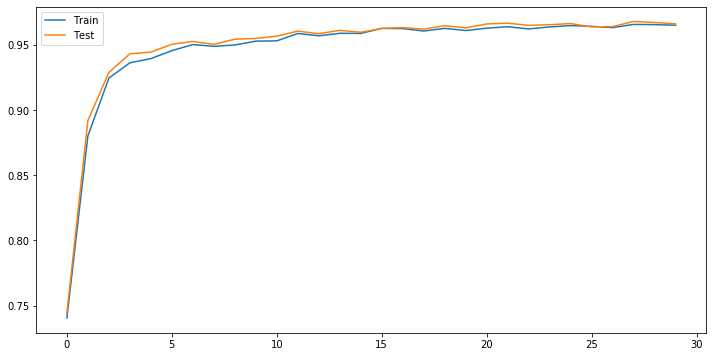

In [10]:
plt.figure(figsize=(12,6))
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
pass

In [11]:
test_acc[-1]

0.9661

# Quantization

In [12]:
dummy = torch.zeros(1,1,28,28, dtype=torch.float)
test_iterations = 10000

### test time & size before quantization

In [13]:
model.eval()

time_start = time.time()
for i in range(test_iterations):
    result = model.forward(dummy)
time_stop = time.time()
orig_time = int(1000*(time_stop-time_start))

print(f"Result shape: {result.shape} Test time: {orig_time}ms",)

# Check acc
tloader = tqdm(dataloader)
number = 0
hits = 0
for img, label in tloader: 
    output = model(img)
    number += output.shape[0]
    output = output.detach().numpy()
    label = label.detach().numpy()
    hits += np.sum( np.argmax(output, axis=1) == label )
print(f"Accuracy: {(hits/number):0.5f}")

torch.save(model.state_dict(),"orig.pth")
print(f"Model file size: {os.path.getsize('orig.pth')}")

Result shape: torch.Size([1, 10]) Test time: 5280ms



Accuracy: 0.96505
Model file size: 13595


### perform quantization

In [14]:
%%time

pmodel = quantization.fuse_modules(model, [['conv1','relu1'],['conv2','relu2'],['conv3','relu3']])

# Prepare for stats collection
qmodel = quantization.prepare(pmodel,{"":quantization.default_qconfig})

# Gather stats
tloader = tqdm(dataloader)
for img, _ in tloader: 
    output = qmodel(img)

## Convert model
qmodel = quantization.convert(qmodel)

# first layer scale
print(qmodel.conv1)
print(qmodel.fc)


QuantizedConvReLU2d(1, 8, kernel_size=(3, 3), stride=(2, 2), scale=0.05126289278268814, zero_point=0, padding=(2, 2))
QuantizedLinear(in_features=32, out_features=10, scale=0.334920734167099, zero_point=58)
CPU times: user 8.4 s, sys: 150 ms, total: 8.55 s
Wall time: 8.74 s


### test time & size after quantization

In [17]:
qmodel.eval()
qdummy = torch.quantize_per_tensor(dummy, scale=1, zero_point=0, dtype=torch.quint8) 

time_start = time.time()
for i in range(test_iterations):
    result = qmodel.forward(qdummy)
time_stop = time.time()
q_time = int(1000*(time_stop-time_start))

print(f"Result shape: {result.shape} Test time: {q_time}ms",)

# Check acc
tloader = tqdm(dataloader_test)
number = 0
hits = 0
for img, label in tloader: 
    img = torch.quantize_per_tensor(img, scale=1, zero_point=0, dtype=torch.quint8) 
    output = qmodel(img)
    number += output.shape[0]
    output = torch.dequantize(output).detach().numpy()
    label = label.detach().numpy()
    hits += np.sum( np.argmax(output, axis=1) == label )
print(f"Accuracy: {(hits/number):0.5f}")

torch.save(qmodel.state_dict(),"q.pth")
print(f"QModel file size: {os.path.getsize('q.pth')}")

Result shape: torch.Size([1, 10]) Test time: 2763ms



Accuracy: 0.94980
QModel file size: 5792
